In [5]:
# import relevant packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn_pandas import DataFrameMapper

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize':(24, 12)})

In [8]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [3]:
import io

In [9]:
# convert train adn tests csv files into pandas dataframes
train_data = pd.read_csv(io.BytesIO(uploaded['train.csv']))
test_data = pd.read_csv(io.BytesIO(uploaded['test.csv']))

In [10]:
# function to clean data
def clean_data(csv_data, data):
    """
    takes in train data and removes bad features and logs the target variable
    returns X and y
    """

    X = csv_data.copy()

    # list of columns to remove (all except 3 are AllPub for utilities)
    # garage cars is proportional to garage area and is repetitive (gar area correlates better with saleprice, too)
    columns = ['Id', 'Utilities', 'GarageCars', 'MasVnrType', 'MasVnrArea', 'PoolQC', 'Fence', 'Street']
    X.drop(columns=columns, inplace=True)
    # sns.scatterplot(X_train['GarageCars'], X_train['GarageArea'])
    # sns.barplot(X_train['Utilities'].value_counts().axes[0], X_train['Utilities'].value_counts())

    # fill in some nan values
    X["MiscFeature"] = X["MiscFeature"].fillna("None")
    X["Alley"] = X["Alley"].fillna("None")
    X["FireplaceQu"] = X["FireplaceQu"].fillna("None")

    # no garage residences can be filled in with None
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        X[col] = X[col].fillna('None')

    for col in ('GarageYrBlt', 'GarageArea'):
        X[col] = X[col].fillna(0)

    # for residences without basements
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        X[col] = X[col].fillna(0)

    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        X[col] = X[col].fillna('None')

    # # likely no masonry veneer for these houses
    # From this we can see that this feature has negligible correlation with SalePrice,
    # and the values for this feature vary widely based on house type, style and size.
    # X["MasVnrType"] = X["MasVnrType"].fillna("None")
    # X["MasVnrArea"] = X["MasVnrArea"].fillna(0)

    # choose the mode for electrical (only one missing, with )
    X['Electrical'] = X['Electrical'].fillna(X['Electrical'].mode()[0])
    # sns.barplot(X_train['Electrical'].value_counts().axes[0], X_train['Electrical'].value_counts())

    # most kitchens are of typical quality, good is close second
    X['KitchenQual'] = X['KitchenQual'].fillna(X['KitchenQual'].mode()[0])
    # sns.barplot(X_train['KitchenQual'].value_counts().axes[0], X_train['KitchenQual'].value_counts())

    # replace with most popular exterior build (both vinylSd)
    X['Exterior1st'] = X['Exterior1st'].fillna(X['Exterior1st'].mode()[0])
    X['Exterior2nd'] = X['Exterior2nd'].fillna(X['Exterior2nd'].mode()[0])

    #  Fill in again with most frequent which is "WD"
    X['SaleType'] = X['SaleType'].fillna(X['SaleType'].mode()[0])

    # Na most likely means No building class
    X['MSSubClass'] = X['MSSubClass'].fillna("None")

    # for functional, NA means typical
    X["Functional"] = X["Functional"].fillna("Typ")


    # transform numerical to categorical
    X['MSSubClass'] = X['MSSubClass'].apply(str)
    
    # fill in with most frequent value based on MSzoning
    X['MSZoning'] = X.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    X['MSZoning'] = X['MSZoning'].apply(str)
    
    # even though 1-10, it's categorical
    X['OverallCond'] = X['OverallCond'].astype(str)

    #Year and month sold are transformed into categorical features.
    X['YrSold'] = X['YrSold'].astype(str)
    X['MoSold'] = X['MoSold'].astype(str)

    # just verify whether the house has a pool or not
    X['HasPool'] = X['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    X.drop(columns=['PoolArea'], inplace=True)

    # use labelencoder for categorical data
    cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
            'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
            'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
            'LotShape', 'PavedDrive', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
            'YrSold', 'MoSold')

    # process columns, apply LabelEncoder to categorical features
    for c in cols:
        lbl = LabelEncoder()
        X[c] = lbl.fit_transform(list(X[c].values))

    # filled in lotfrontage based on neighborhood means
    X["LotFrontage"] = X.groupby("BldgType")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

    if data == 'train':
        X['SalePrice'] = np.log(X['SalePrice'])
    else:
        None
    
    return X


In [11]:
# run the functions
X_train = clean_data(train_data, data='train')
X_test = clean_data(test_data, data='test')

# filter out outlier data based on living area space
X_train = X_train[~(X_train['GrLivArea'] > 4000)]
X_train = X_train[~((X_train['Neighborhood'] == 'NAmes') & (X_train['LotFrontage'] > 250))]
X_train = X_train[~(X_train['HouseStyle'] == '2.5Fin')]

print(X_train.shape)

X_train.reset_index(drop=True, inplace=True)

y_train = X_train['SalePrice']

(1447, 73)


In [12]:
# feature engineering
# Adding total sqfootage feature (including basement)
# corr = 0.825496
X_train['TotalSF'] = X_train['1stFlrSF'] + X_train['2ndFlrSF'] + X_train['TotalBsmtSF']
X_test['TotalSF'] = X_test['1stFlrSF'] + X_test['2ndFlrSF'] + X_test['TotalBsmtSF']
# sns.scatterplot(X_train['TotalSF'], y_train, label='total sf')

# total number of bathrooms (halfbaths count as half of one)
# corr = 0.640868
X_train['TotalBath'] = X_train['FullBath'] + (0.5 * X_train['HalfBath'])
X_test['TotalBath'] = X_test['FullBath'] + (0.5 * X_test['HalfBath'])

# calculate the price per square meter, linked to each neighborhood or class of housing
X_train['Sqr'] = X_train['SalePrice'] / X_train['LotArea']
X_train['Sqr'] = X_train.groupby('Neighborhood')['Sqr'].transform(lambda x: x.median())

# apply these found values to become a feature for the test data
d = {}
for indice_fila, x_train in X_train.iterrows():
    d.update({x_train['Neighborhood']:x_train['Sqr']})

X_test['Sqr'] = 0.00
for indice, x_test in X_test.iterrows():
    X_test.loc[X_test.index == indice, 'Sqr'] = d[x_test['Neighborhood']]

# X_test had nan values for mszoning, replaced with most frequent value
X_test['MSZoning'] = X_test['MSZoning'].replace(['nan'], 'RL')

In [13]:
from sklearn.preprocessing import power_transform

def fix_skew(data):
  # 60 features out of 72 are numeric
  data_corr = data.select_dtypes(include=[np.number])
  # data_corr.head()

  skew_feat = data_corr.skew().sort_values(ascending=False)
  skewness = pd.DataFrame({'Skew': skew_feat})

  # get the column names that exhibit skew values above 0.5
  highest_skew =  skewness[skewness > 0.5].index
  skew_data = data_corr.loc[:, highest_skew]

  # yeo-johnson is used bc of so much null datat (box-cox requires only positive data)
  skew_df = pd.DataFrame(power_transform(skew_data, method='yeo-johnson'))
  skew_df.columns = highest_skew

  # replace skewed columns with newly yoe-johnson transformed columns
  for column in skew_df.columns:
      data[column] = skew_df[column].reset_index(drop=True)

  return data

In [14]:
X_train = fix_skew(X_train)
X_test = fix_skew(X_test)

In [15]:
X_train.skew().sort_values(ascending=False)[0:10]

HasPool          16.941026
LowQualFinSF      8.562896
3SsnPorch         7.578098
MiscVal           4.991577
LandSlope         4.047463
BsmtHalfBath      3.867104
ScreenPorch       3.112720
BsmtFinSF2        2.409812
EnclosedPorch     2.041075
Alley             0.759315
dtype: float64

In [16]:
# condition2 = Proximity to various conditions (if more than one is present)
X_train = X_train.drop(columns=['Condition2', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Heating', 'Electrical', 'MiscFeature'])
X_test = X_test.drop(columns=['Condition2', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Heating', 'Electrical', 'MiscFeature'])

SalePrice       1.000000
TotalSF         0.824530
OverallQual     0.816506
GrLivArea       0.736842
GarageArea      0.652138
YearBuilt       0.635153
TotalBath       0.634905
TotalBsmtSF     0.634764
1stFlrSF        0.609262
FullBath        0.587511
YearRemodAdd    0.565363
TotRmsAbvGrd    0.540581
Fireplaces      0.508305
OpenPorchSF     0.464691
GarageYrBlt     0.390844
Name: SalePrice, dtype: float64


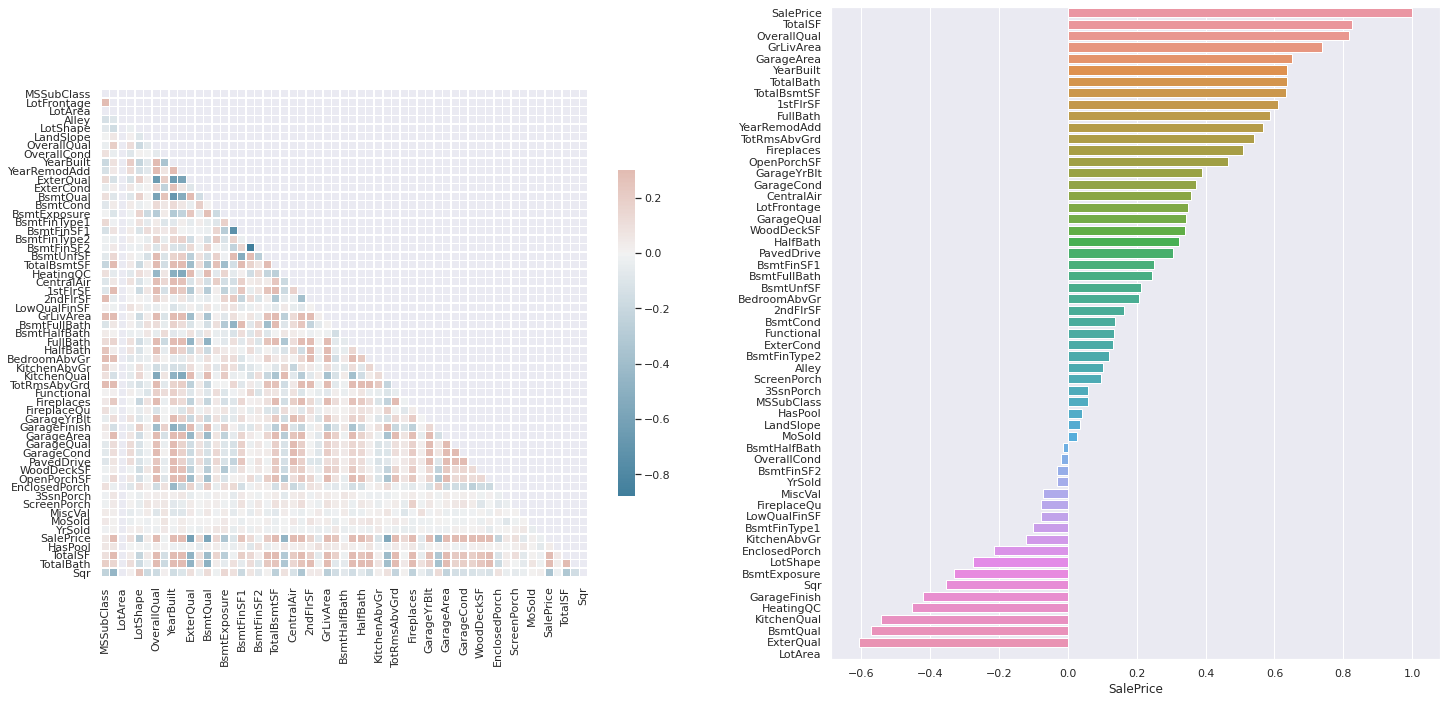

In [17]:
#Correlation map to see how features are correlated with SalePrice
# sns.set(rc={'figure.figsize':(24, 12)})

fig, axes = plt.subplots(1, 2)
corr = X_train.corr()

# to brighten out the top diagonal matrix
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axes[0])

# barplot for correlation matrix
corr.sort_values(['SalePrice'], ascending=False, inplace=True)
sns.barplot(corr['SalePrice'], corr['SalePrice'].axes[0], ax=axes[1])

# list top 10 variables that correspond to saleprice
print(corr['SalePrice'][0:15])

In [18]:
# convert categorical variables into dummy variables while dropping SalePrice from feature set
X_train = pd.get_dummies(X_train).drop(columns=['SalePrice'])
X_test = pd.get_dummies(X_test)

not_lst = [column for column in X_test.columns if column not in X_train.columns]
nt_lst = [column for column in X_train.columns if column not in X_test.columns]


not_lst, nt_lst

([], [])

In [19]:
# make a validation set 
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.25)

In [21]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
xgb = XGBRegressor()

xgb.fit(train_X, train_y, verbose=False)

# make predictions
y_pred = xgb.predict(val_X)
print("RMSE: " + str(mean_squared_error(y_pred, val_y, squared=False)))

[20:57:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.14079045780015517


In [26]:
# Various hyper-parameters to tune
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

xgb1 = XGBRegressor()
parameters = {'objective': ['reg:squarederror'],
              'eval_metric': ['rmse'],
              'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'min_child_weight': [2, 3, 4],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_depth': [5, 7, 10, 12, 15, 20, 30],
              'n_estimators': [100, 200, 400, 600, 800, 1000, 1200]}

xgb_model = RandomizedSearchCV(xgb1,
                               parameters,
                               cv = 5,
                               n_jobs = -1,
                               verbose=True)

xgb_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                   param_distributions={'eval_metric': ['rmse'],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'm

In [28]:
print(xgb_model.best_score_)
print(xgb_model.best_params_)

0.9049995668505808
{'objective': 'reg:squarederror', 'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'eval_metric': 'rmse'}


In [ ]:
xgboost = XGBRegressor(objective = 'reg:squarederror',
                       n_estimators = 1200,
                       min_samples_split = 2, 
                       min_samples_leaf = 4,
                       min_child_weight = 3,
                       max_depth = 7,
                       learning_rate = 0.1,
                       eval_metric = 'rmse')

xgboost.fit(X_train, y_train)

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score

# Setup cross validation folds
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X, y_train, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [31]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))
ridge.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('ridgecv',
                 RidgeCV(alphas=array([1.0e-15, 1.0e-10, 1.0e-08, 9.0e-04, 7.0e-04, 5.0e-04, 3.0e-04,
       1.0e-04, 1.0e-03, 5.0e-02, 1.0e-02, 1.0e-01, 3.0e-01, 1.0e+00,
       3.0e+00, 5.0e+00, 1.0e+01, 1.5e+01, 1.8e+01, 2.0e+01, 3.0e+01,
       5.0e+01, 7.5e+01, 1.0e+02]),
                         cv=KFold(n_splits=5, random_state=42, shuffle=True),
                         fit_intercept=True, gcv_mode=None, normalize=False,
                         scoring=None, store_cv_values=False))],
         verbose=False)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Parameters for tuning
parameters = {'loss': ['ls', 'huber'],
              'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'max_depth': [3, 4, 5, 6],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'n_estimators': [100, 200, 400, 600, 800, 1000, 1200]}

gbr = RandomizedSearchCV(GradientBoostingRegressor(),
                   param_distributions=parameters,
                   cv=5,
                   n_jobs=-1,
                   scoring='neg_mean_squared_error',
                   verbose=True)

# Gradient Boosting Regressor
gbr.fit(X_train, y_train)


In [ ]:
print(gbr.best_params_)

gboost = GradientBoostingRegressor(n_estimators = 1000,
                                   min_samples_split = 5,
                                   min_samples_leaf = 4,
                                   max_depth = 4,
                                   loss = 'ls',
                                   learning_rate = 0.01
)

gboost.fit(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Parameters for tuning
parameters = {'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_depth': [5, 7, 10, 12, 15, 20, 30],
              'n_estimators': [100, 200, 400, 600, 800, 1000, 1200]}

rand_for = RandomizedSearchCV(RandomForestRegressor(),
                   param_distributions=parameters,
                   cv=5,
                   n_jobs=-1,
                   scoring='neg_mean_squared_error',
                   verbose=True)

rand_for.fit(X_train, y_train)

In [37]:
print(rand_for.best_params_)

rf = RandomForestRegressor(n_estimators = 1200, 
                           min_samples_split = 5,
                           min_samples_leaf = 1,
                           max_depth = 30
)

rf.fit(X_train, y_train)

{'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=1200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [41]:
ridge_score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(ridge_score.mean(), ridge_score.std()))

xgb_score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(xgb_score.mean(), xgb_score.std()))

rf_score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(rf_score.mean(), rf_score.std()))

gboost_score = cv_rmse(gboost)
print("gboost: {:.4f} ({:.4f})".format(gboost_score.mean(), gboost_score.std()))

ridge: 0.1148 (0.0104)
xgboost: 0.1226 (0.0115)
rf: 0.1370 (0.0110)
gboost: 0.1240 (0.0120)


In [89]:
scores = [ridge_score.mean(), xgb_score.mean(), rf_score.mean(), gboost_score.mean()]
models = ['Ridge', 'XGBoost', 'Random Forest', 'Gradient Boosting']

score_df = pd.DataFrame({'Models': models,
                         'RMSE' : scores})

In [90]:
score_df

,Models,RMSE
0,Ridge,0.114790
1,XGBoost,0.122587
2,Random Forest,0.137031
3,Gradient Boosting,0.124028


In [83]:
# ax = score_df.plot.bar('Models','RMSE')
# ax.set_ylim(.10,.14)

In [ ]:
# Stack up all the models above, optimized using xgboost
from mlxtend.regressor import StackingCVRegressor
stack_gen = StackingCVRegressor(regressors=(xgboost, gboost, ridge, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

stack_gen.fit(np.array(X_train), np.array(y_train))

In [81]:
def blended_predictions(X):
    return ((0.1 * xgboost.predict(X)) + \
            (0.2 * ridge.predict(X)) + \
            (0.1 * rf.predict(X)) + \
            (0.2 * gboost.predict(X)) + \
            (0.4 * stack_gen.predict(np.array(X))))

In [82]:
# Get final precitions from the blended model
blended_score = rmsle(y_train, blended_predictions(X_train))
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.04388598982410183


In [80]:
model_pred = np.exp(blended_predictions(X_test))

solution = pd.DataFrame({"id": test_data.Id, "SalePrice": model_pred})

# q1 = solution['SalePrice'].quantile(0.005)
# q2 = solution['SalePrice'].quantile(0.995)
# solution['SalePrice'] = solution['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
# solution['SalePrice'] = solution['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

solution.to_csv("stacked6.csv", index=False)
files.download("stacked6.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>